In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import product
from dateutil.relativedelta import relativedelta

import scipy.stats as scs
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from scipy.optimize import minimize

from sklearn.metrics import mean_absolute_error, mean_squared_error

from tqdm.notebook import tqdm
from tqdm import tqdm_notebook

from sklearn.model_selection import train_test_split # разбиение данных на тренировочные и тестовые


from sklearn.preprocessing import StandardScaler # нормализация и масштабирование данных

from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import cross_val_score # кроссвалидация
from sklearn.model_selection import GridSearchCV # подбор гиперпараметров с кроссвалидацией

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV, RidgeCV
from xgboost import XGBRegressor

import statsmodels


import gc
import glob
import os
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from numpy import percentile
from sklearn.metrics import f1_score

# sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples
from tqdm import tqdm
from tensorflow.keras.models import load_model

from itertools import product

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout, Activation
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/k8s/datasets/nabout.csv")

df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df_anomaly = df.copy()
df = df[['cpu_usage',	'net_usage',	'disk_usage']]
df

,cpu_usage,net_usage,disk_usage
timestamp,,,
2014-02-14 14:30:00,0.132,236906.0,43216100.0
2014-02-14 14:35:00,0.134,247200.0,863964000.0
2014-02-14 14:40:00,0.134,244932.0,128310000.0
2014-02-14 14:45:00,0.134,249894.0,0.0
2014-02-14 14:50:00,0.134,226273.0,125814000.0
...,...,...,...
2014-03-13 14:04:00,0.066,219813.0,7878250.0
2014-03-13 14:09:00,0.068,207644.0,107195000.0
2014-03-13 14:14:00,0.134,204319.0,44328600.0


In [ ]:
for column in df.columns:
    fig = px.line(df, x=df.index, y=[column], title='AWS ' + column, template = 'plotly_dark')
    fig.show()

# LSTM

In [ ]:
df_sc = df.copy()
column_usage = 'cpu_usage'

scaler = StandardScaler()
scaler = scaler.fit(df_sc[[column_usage]])

df_sc[column_usage] = scaler.transform(df[[column_usage]])

In [ ]:
seq_size = 95

In [ ]:
def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        #print(i)
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])

    return np.array(x_values), np.array(y_values)

In [ ]:
X, Y = to_sequences(df_sc[[column_usage]], df_sc[column_usage], seq_size)

Y = np.reshape(Y, (Y.shape[0], 1))
df_sc = df_sc.iloc[seq_size:, :]
df = df.iloc[seq_size:, :]

In [ ]:
model = Sequential()
model.add(LSTM(40, return_sequences = True, input_shape=(X.shape[1], X.shape[2])))
model.add(Activation('selu'))
model.add(Dropout(rate=0.2))

model.add(LSTM(40, return_sequences = True))
model.add(Activation('selu'))
model.add(Dropout(rate=0.2))

model.add(LSTM(40, return_sequences = True))
model.add(Activation('selu'))
model.add(Dropout(rate=0.2))

model.add(LSTM(40))
model.add(Activation('selu'))
model.add(Dropout(rate=0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 95, 40)            6720      
                                                                 
 activation (Activation)     (None, 95, 40)            0         
                                                                 
 dropout (Dropout)           (None, 95, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 95, 40)            12960     
                                                                 
 activation_1 (Activation)   (None, 95, 40)            0         
                                                                 
 dropout_1 (Dropout)         (None, 95, 40)            0         
                                                                 
 lstm_2 (LSTM)               (None, 95, 40)            1

In [ ]:
history = model.fit(X, Y, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/20
216/216 [==============================] - 33s 121ms/step - loss: 0.2799 - val_loss: 0.2561
Epoch 2/20
216/216 [==============================] - 24s 113ms/step - loss: 0.2678 - val_loss: 0.2638
Epoch 3/20
216/216 [==============================] - 25s 117ms/step - loss: 0.2650 - val_loss: 0.2269
Epoch 4/20
216/216 [==============================] - 26s 121ms/step - loss: 0.2609 - val_loss: 0.2361
Epoch 5/20
216/216 [==============================] - 25s 117ms/step - loss: 0.2603 - val_loss: 0.2262
Epoch 6/20
216/216 [==============================] - 25s 117ms/step - loss: 0.2583 - val_loss: 0.2357
Epoch 7/20
216/216 [==============================] - 25s 117ms/step - loss: 0.2577 - val_loss: 0.2292
Epoch 8/20
216/216 [==============================] - 26s 119ms/step - loss: 0.2576 - val_loss: 0.2274
Epoch 9/20
216/216 [==============================] - 24s 112ms/step - loss: 0.2576 - val_loss: 0.2253
Epoch 10/20
216/216 [==============================] - 25s 117ms/step - l

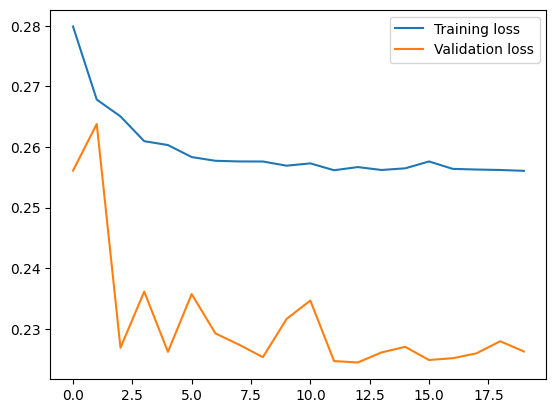

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
fig = px.line(df,
              x=df.index,
              y=[scaler.inverse_transform(df_sc[[column_usage]]).flatten(),
                  scaler.inverse_transform(model.predict(X)).flatten()],
              title='AWS ' + column,
              template = 'plotly_dark')
fig.show()

240/240 [==============================] - 10s 33ms/step


In [ ]:
mean_absolute_error(df_sc[[column_usage]], model.predict(X))

240/240 [==============================] - 9s 38ms/step


0.24506564990619387

In [ ]:
pred_residuals = df_sc[[column_usage]] - model.predict(X)

240/240 [==============================] - 9s 38ms/step


In [ ]:
print(pred_residuals)
UCL = pd.DataFrame(pred_residuals).abs().sum(axis=1).quantile(0.95)
print(UCL)

fig = px.line(pred_residuals,
              x=df.index,
              y=[pred_residuals.iloc[:, 0]],
              title='График разностей сигналов',
              template = 'plotly_dark')
fig.show()

                     cpu_usage
timestamp                     
2014-02-14 22:25:00   0.010914
2014-02-14 22:30:00  -0.010481
2014-02-14 22:35:00  -0.702249
2014-02-14 22:40:00  -0.010564
2014-02-14 22:45:00  -0.010787
...                        ...
2014-03-13 14:04:00  -0.021942
2014-03-13 14:09:00   0.000700
2014-03-13 14:14:00   0.711557
2014-03-13 14:19:00   0.005110
2014-03-13 14:24:00   0.003934

[7680 rows x 1 columns]
0.7241507423987934


In [ ]:
fig = px.line(df,
              x=df.index,
              y=[pd.DataFrame(pred_residuals, index=df.index).abs().sum(axis=1).values, np.full(shape=len(pred_residuals),fill_value=UCL,dtype=np.float64 )],
              title='График разностей сигналов',
              template = 'plotly_dark')
fig.show()

In [ ]:
dfx = df.copy()
dfx['is_outlier'] = pd.DataFrame(pred_residuals, index=df.index).abs().sum(axis=1) > UCL
dfx["outlier"] = dfx["is_outlier"].astype(int)
dfx

,cpu_usage,net_usage,disk_usage,is_outlier,outlier
timestamp,,,,,
2014-02-14 22:25:00,0.134,86.4,0.0,False,0
2014-02-14 22:30:00,0.132,68.4,0.0,False,0
2014-02-14 22:35:00,0.068,42.0,0.0,False,0
2014-02-14 22:40:00,0.132,112.8,0.0,False,0
2014-02-14 22:45:00,0.132,68.4,0.0,False,0
...,...,...,...,...,...
2014-03-13 14:04:00,0.066,219813.0,7878250.0,False,0
2014-03-13 14:09:00,0.068,207644.0,107195000.0,False,0
2014-03-13 14:14:00,0.134,204319.0,44328600.0,False,0


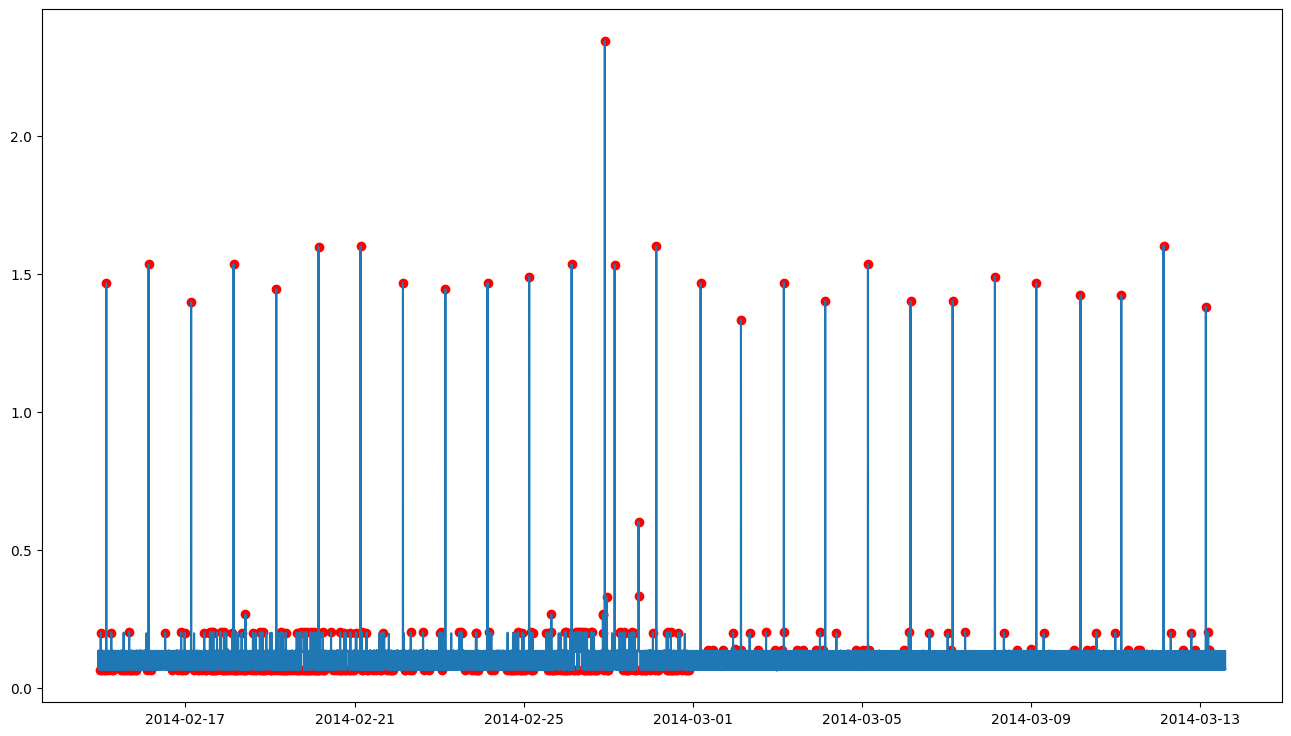

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
a = dfx.loc[dfx.outlier == 1, [column_usage]]

ax.plot(dfx.index, dfx[column_usage])
ax.scatter(a.index, a[column_usage], color='red')
plt.show()

In [ ]:
y_pred = dfx['outlier']
colors = ['green' if a == 0 else 'red' for a in y_pred]

# Create a scatter plot of the data with anomalies highlighted in red
fig = go.Figure(data=go.Scatter(x=dfx.index, y=dfx[column_usage],
                                 mode='markers', marker=dict(color=colors, size=3)))

# Set the title and axis labels for the plot
fig.update_layout(title=dict(text='LOF Anomaly prediction', x=0.5),
                  yaxis_title='Value',
                  xaxis_title='Timestamp')

# Show the plot
fig.show()

# Metrics


In [ ]:
y_pred = y_pred == 0
dfx['name'] = y_pred
y_pred

timestamp
2014-02-14 22:25:00    True
2014-02-14 22:30:00    True
2014-02-14 22:35:00    True
2014-02-14 22:40:00    True
2014-02-14 22:45:00    True
                       ... 
2014-03-13 14:04:00    True
2014-03-13 14:09:00    True
2014-03-13 14:14:00    True
2014-03-13 14:19:00    True
2014-03-13 14:24:00    True
Name: outlier, Length: 7680, dtype: bool

In [ ]:
p_values = {}
p_stats_ = {}
percent = {}
silhoutte = {}
calinski_harabasz = {}
davies_bouldin = {}

scaler = MinMaxScaler()
X = df.copy()
X = scaler.fit_transform(X)

cols_in = [column_usage]

In [ ]:
dfx['name'].value_counts()

True     7296
False     384
Name: name, dtype: int64

In [ ]:
#percent anomaly
dist = dfx['name'].value_counts(normalize=True)
print(dist)
percent['name'] = dist.loc[True]

True     0.95
False    0.05
Name: name, dtype: float64


In [ ]:
#silhouette conficient samples non-anomaly
labels = [1 if i == True else 2 for i in dfx['name']]
dfx['silhouette_zcore_'] = silhouette_samples(df[[column_usage]], labels)
silhoutte['name'] = dfx[dfx['name']]['silhouette_zcore_'].mean()

In [ ]:
#ks coeficient
normal = dfx.loc[dfx['name'] == False, [column_usage]]
anomaly = dfx.loc[dfx['name'] == True, [column_usage]]
for col_in in tqdm(cols_in):
  if len(normal)>0 and len(anomaly)>0:
    stats_, pvalue = stats.kstest(normal[col_in], anomaly[col_in])
    p_values[col_in+'_'] = pvalue
    p_stats_[col_in+'_'] = stats_

100%|██████████| 1/1 [00:00<00:00, 55.86it/s]


In [ ]:
from sklearn.metrics import calinski_harabasz_score

ch_index = calinski_harabasz_score(df[[column_usage]], labels)
calinski_harabasz['name'] = round(ch_index, 3)
print("Calinski-Harabasz Index:", round(ch_index, 3))

Calinski-Harabasz Index: 595.332


In [ ]:
from sklearn.metrics import davies_bouldin_score

dbi = davies_bouldin_score(df[[column_usage]], labels)
davies_bouldin['name'] = round(dbi, 3)
print("Davies-Bouldin Index:", round(dbi, 3))

Davies-Bouldin Index: 1.98


pvalue
  svm_algorithm        pvalue
0    cpu_usage_  5.162491e-52
{'cpu_usage_': 5.162491227061519e-52}


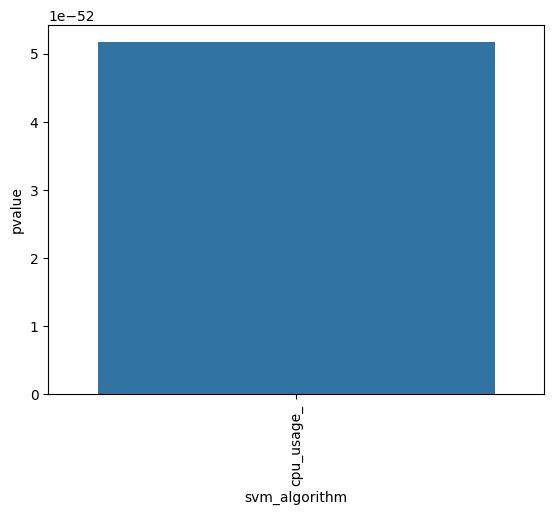

statistics
  svm_algorithm  statistics
0    cpu_usage_    0.396107
{'cpu_usage_': 0.39610745614035087}


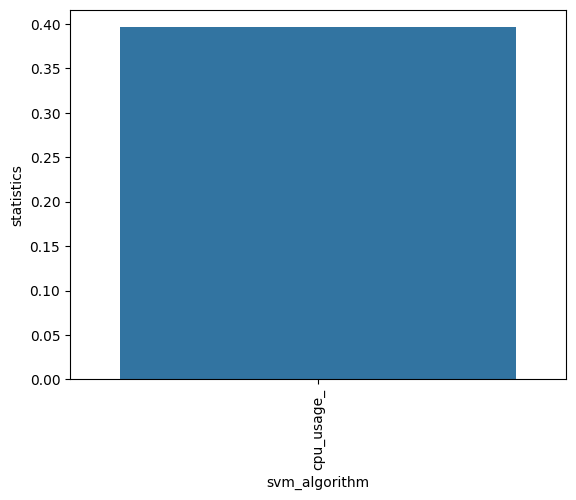

percent
  svm_algorithm  percent
0          name     0.95
{'name': 0.95}


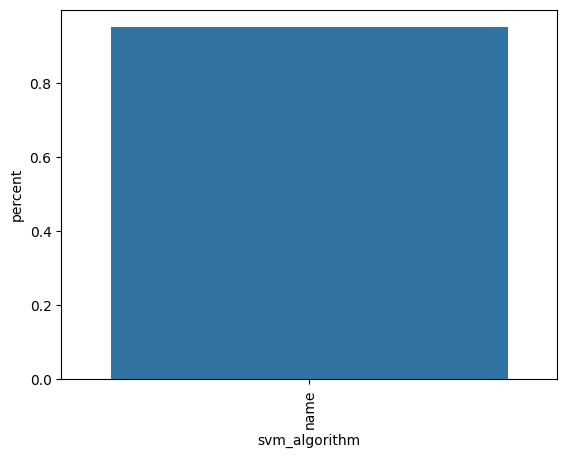

silhoutte
  svm_algorithm  silhoutte
0          name   0.776094
{'name': 0.7760935250297449}


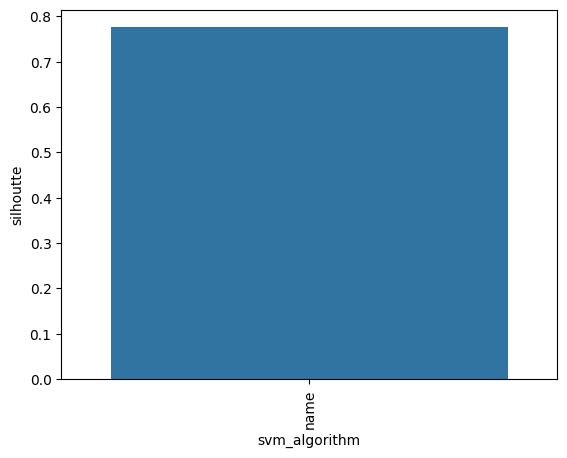

calinski_harabasz
  svm_algorithm  calinski_harabasz
0          name            595.332
{'name': 595.332}


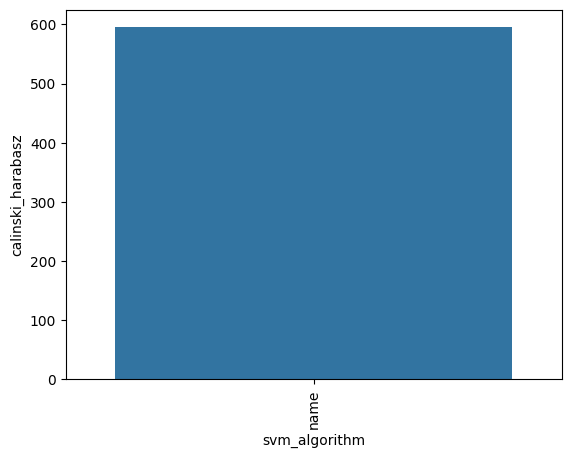

davies_bouldin
  svm_algorithm  davies_bouldin
0          name            1.98
{'name': 1.98}


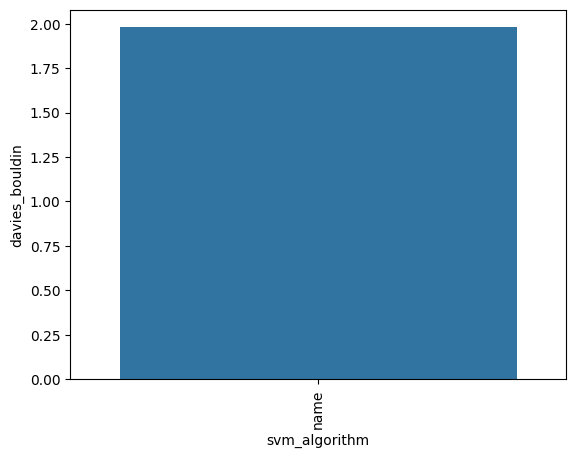

In [ ]:
for name, dictionary in {'pvalue': p_values, 'statistics': p_stats_, 'percent': percent, 'silhoutte':silhoutte, 'calinski_harabasz': calinski_harabasz, 'davies_bouldin': davies_bouldin}.items():
    print(name)
    df_values =  pd.DataFrame([dictionary])
    df_values = df_values.T
    df_values.reset_index(inplace=True)
    df_values.columns = ['svm_algorithm', name]
    print(df_values)
    print(dictionary)

    sns.barplot(data=df_values, x='svm_algorithm', y=name)
    plt.xticks(df_values.index, df_values['svm_algorithm'].values, rotation=90)
    plt.show()

In [ ]:
for name, dictionary in {'pvalue': p_values, 'statistics': p_stats_, 'percent': percent, 'silhoutte':silhoutte, 'calinski_harabasz': calinski_harabasz, 'davies_bouldin': davies_bouldin}.items():
    print(name + ': ' + str(np.array(list(dictionary.values())).mean()))

pvalue: 5.162491227061519e-52
statistics: 0.39610745614035087
percent: 0.95
silhoutte: 0.7760935250297449
calinski_harabasz: 595.332
davies_bouldin: 1.98


In [ ]:
df_anomaly = df_anomaly.iloc[seq_size:, :]
svm_df = pd.DataFrame()
svm_df['anomaly']  = [1 if i==True else 0 for i in df_anomaly.anomaly]

svm_f1 = f1_score(dfx['outlier'], svm_df['anomaly'])
print(f'One Class SVM F1 Score : {round(svm_f1 * 100,2)}%')

One Class SVM F1 Score : 10.86%


# Save Model

In [ ]:
 model.save('/content/drive/MyDrive/Colab Notebooks/k8s/models/model_lstm_nab_' + column_usage + '.h5')
